In [ ]:
! pip install kaggle

In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.optimizers import Adam
import os
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split

In [ ]:
# Upload the kaggle.json file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alisafaeii","key":"8de2ffef8b36d2ccfd13c6915618c03d"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d maparla/prado-museum-pictures

Dataset URL: https://www.kaggle.com/datasets/maparla/prado-museum-pictures
License(s): MIT
100% 24.9G/24.9G [25:06<00:00, 13.8MB/s]
100% 24.9G/24.9G [25:06<00:00, 17.8MB/s]


In [ ]:
# Unzip the downloaded file
!unzip prado-museum-pictures.zip -d /content/prado-museum-pictures

Streaming output truncated to the last 5000 lines.
  inflating: /content/prado-museum-pictures/images/images/a00e794e-928d-40b7-b93d-25a717cbe928.jpg  
  inflating: /content/prado-museum-pictures/images/images/a01de9ba-e790-457d-8b08-0312bd49f8ee.jpg  
  inflating: /content/prado-museum-pictures/images/images/a0215d66-768d-4b08-9f45-5debe380e3cc.jpg  
  inflating: /content/prado-museum-pictures/images/images/a0234db3-6160-47ec-a62f-ae4585b30cfe.jpg  
  inflating: /content/prado-museum-pictures/images/images/a02862ca-52ef-4aeb-b1c2-0654954c8426.jpg  
  inflating: /content/prado-museum-pictures/images/images/a02a876e-f3fe-40a2-9ea9-8b25a5bda827.jpg  
  inflating: /content/prado-museum-pictures/images/images/a0324706-3b2b-49ca-8877-e7e031e5a487.jpg  
  inflating: /content/prado-museum-pictures/images/images/a034f244-a906-4d5b-9a13-299648fd4498.jpg  
  inflating: /content/prado-museum-pictures/images/images/a034f7c7-f71c-4a52-8f0d-5cd79d2f3c33.jpg  
  inflating: /content/prado-museum-pictu

In [ ]:
# Delete the zip file
!rm prado-museum-pictures.zip

In [ ]:
file_path = '/content/prado-museum-pictures/prado.csv'
df = pd.read_csv(file_path)
df["work_id"] = df['work_image_url'].apply(lambda x: x.split('/')[-1])

for _, row in df.iterrows():
    image_id = row["work_id"]
    image_path = os.path.join("images", image_id)

In [ ]:
# Count the number of technical
unique_names_count = df['technical_sheet_tecnica'].nunique()
print(f"Number of techniques: {unique_names_count}")

Number of techniques: 841


In [ ]:
technical_counts = df['technical_sheet_tecnica'].value_counts()
technical_counts.head(20)

,count
technical_sheet_tecnica,
Óleo,4156
Acuñación,1118
Esculpido,550
Lápiz compuesto,476
Clarión; Lápiz negro,396
Albúmina,395
Sanguina,372
Lápiz,259
Lápiz negro,237


In [ ]:
df1 = pd.DataFrame()

# Concatenating two specific columns from df into df1
df1 = pd.concat([df1, df[['technical_sheet_tecnica', 'work_id']]], axis=1)

In [ ]:
df1

,technical_sheet_tecnica,work_id
0,Lápiz negro,404387d6-a52c-4477-b598-de2a2d5a3d55.jpg
1,Sanguina,589ee4a3-28fa-4977-a84d-7326f5c9aeb3.jpg
2,Óleo,4a8bab74-ca91-450a-b5b7-39dd61e2d7f3.jpg
3,Óleo,9af5b176-b4d3-4930-854b-5b5f252829f1.jpg
4,Óleo,4c494f0a-d5ae-45ca-826b-59f4b5fd4398.jpg
...,...,...
13482,Aguafuerte; Buril; Estampa iluminada,c62f7f3e-3ad3-4d9e-9586-b0b389b2d032.jpg
13483,Entalladura [madera a la fibra],6c28accf-e0c0-4bc0-b4c6-3fbb282bcbd8.jpg
13484,"Aguada de pigmentos opacos [gouache, témpera];...",b4126fb6-c5ac-40e3-89a1-d1578914c09b.jpg
13485,Gelatina / Colodión,e7bf2481-522c-4071-9d97-7908aca45831.jpg


In [ ]:
df_4classes = df1.loc[df['technical_sheet_tecnica'].isin(['Óleo', 'Acuñación', 'Esculpido', 'Lápiz compuesto'])]
df_4classes.reset_index(drop=True, inplace=True)

In [ ]:
shuffled_df_4classes = shuffle(df_4classes).reset_index(drop=True)

In [ ]:
techniques = ['Óleo', 'Acuñación', 'Esculpido', 'Lápiz compuesto']

sampled_images = []

for class_label in techniques:
  sample = shuffled_df_4classes[shuffled_df_4classes['technical_sheet_tecnica'] == class_label].sample(1).iloc[0]
  image_name = sample['work_id']
  label = sample['technical_sheet_tecnica']
  sampled_images.append((image_name, label))

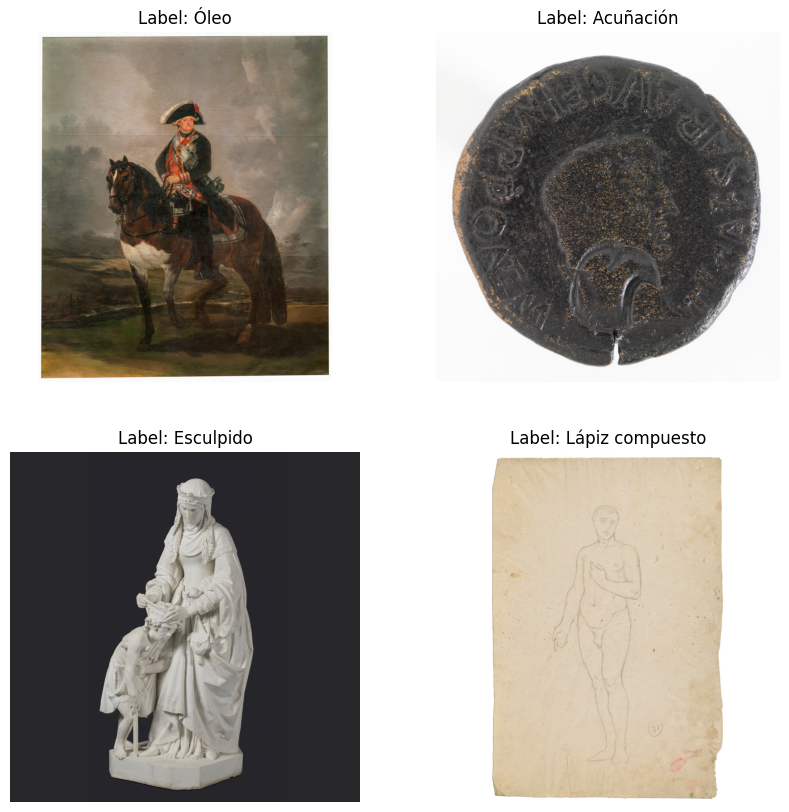

In [ ]:
# Plot the images in a 2x2 grid
plt.figure(figsize=(10, 10))

for i, (image_name, label) in enumerate(sampled_images, 1):
    image_path = os.path.join('/content/prado-museum-pictures/images/images', image_name)
    img = mpimg.imread(image_path)

    plt.subplot(2, 2, i)
    plt.imshow(img)
    plt.title(f"Label: {label}")
    plt.axis('off')


plt.show()

In [ ]:
# Splitting the 4 classes dataset to train and test sets
train_df, test_df = train_test_split(df_4classes, test_size=0.2, stratify=df_4classes['technical_sheet_tecnica'], random_state=42)

In [ ]:
# Resize images to this size
image_size = (224, 224)
# Creating data generator
data_generator = ImageDataGenerator(rescale=1./255)

In [ ]:
# Create the training data generator
path = '/content/prado-museum-pictures/images/images'

train_data = data_generator.flow_from_dataframe(
    dataframe=train_df,
    directory=path,
    x_col='work_id',
    y_col='technical_sheet_tecnica',
    target_size=image_size,
    class_mode='categorical',
    batch_size=32
)

# Create the test data generator
test_data = data_generator.flow_from_dataframe(
    dataframe=test_df,
    directory=path,
    x_col='work_id',
    y_col='technical_sheet_tecnica',
    target_size=image_size,
    class_mode='categorical',
    batch_size=32
)

Found 5034 validated image filenames belonging to 4 classes.
Found 1259 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 6 invalid image filename(s) in x_col="work_id". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="work_id". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
# Define data augmentation layer
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1)
])

# VGG16

In [ ]:
# Define the base model
base_model1 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model1.layers:
    layer.trainable = False

base_model1.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Define the model

model1 = Sequential([
    data_augmentation,
    base_model1,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(4, activation='softmax')
])

In [ ]:
model1.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
early_stop = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)]

Epoch 1/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 323s 2s/step - accuracy: 0.7915 - loss: 0.5647 - val_accuracy: 0.9333 - val_loss: 0.2310
Epoch 2/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 314s 2s/step - accuracy: 0.9663 - loss: 0.1147 - val_accuracy: 0.9706 - val_loss: 0.1063
Epoch 3/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 316s 2s/step - accuracy: 0.9744 - loss: 0.0800 - val_accuracy: 0.9428 - val_loss: 0.1505
Epoch 4/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 309s 2s/step - accuracy: 0.9805 - loss: 0.0630 - val_accuracy: 0.9690 - val_loss: 0.0906
Epoch 5/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 332s 2s/step - accuracy: 0.9835 - loss: 0.0537 - val_accuracy: 0.9587 - val_loss: 0.1269
Epoch 6/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 330s 2s/step - accuracy: 0.9865 - loss: 0.0463 - val_accuracy: 0.9500 - val_loss: 0.1333
Epoch 7/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 362s 2s/step - accuracy: 0.9894 - loss: 0.0385 - val_accuracy: 0.9666 - val_loss: 0.1044
40/40 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.9678 - loss: 0.1132
Test Loss: 0.10440056025

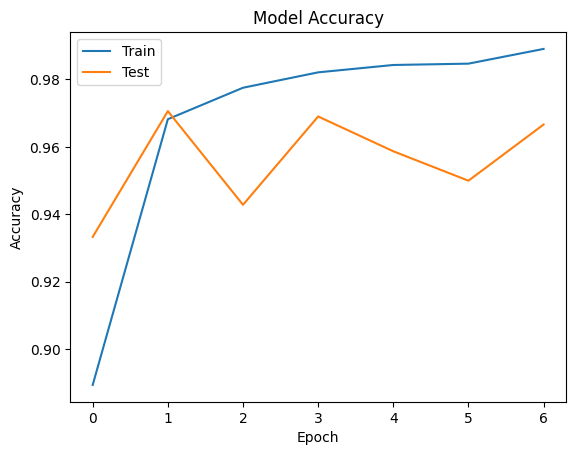

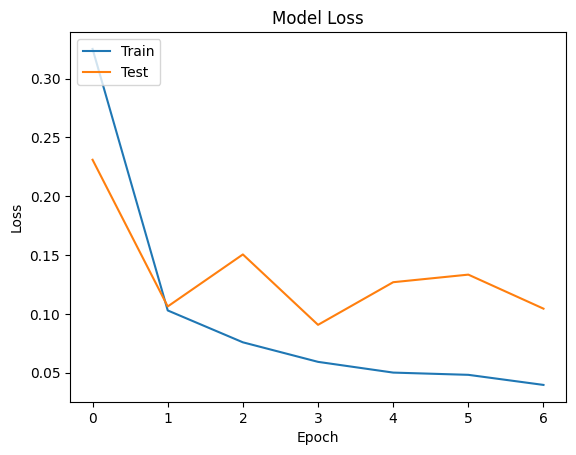

In [ ]:
history = model1.fit(
    x = train_data,
    epochs=20,
    validation_data=test_data,
    callbacks=early_stop
)

test_loss, test_accuracy = model1.evaluate(test_data)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)


# Plot training and test accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training and test loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# ResNet50

In [ ]:
# Define the base model
base_model2 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model2.layers:
    layer.trainable = False

base_model2.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Define the model

model2 = Sequential([
    data_augmentation,
    base_model2,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(4, activation='softmax')
])

In [ ]:
model2.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
early_stop = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)]

Epoch 1/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 336s 2s/step - accuracy: 0.6564 - loss: 0.9715 - val_accuracy: 0.7990 - val_loss: 0.6815
Epoch 2/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 313s 2s/step - accuracy: 0.7662 - loss: 0.6143 - val_accuracy: 0.8475 - val_loss: 0.5085
Epoch 3/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - accuracy: 0.8363 - loss: 0.4657 - val_accuracy: 0.9047 - val_loss: 0.4255
Epoch 4/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 310s 2s/step - accuracy: 0.8767 - loss: 0.3777 - val_accuracy: 0.9126 - val_loss: 0.3582
Epoch 5/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 306s 2s/step - accuracy: 0.8765 - loss: 0.3634 - val_accuracy: 0.9102 - val_loss: 0.3710
Epoch 6/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 306s 2s/step - accuracy: 0.8882 - loss: 0.3336 - val_accuracy: 0.9158 - val_loss: 0.3251
Epoch 7/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 342s 2s/step - accuracy: 0.9047 - loss: 0.2874 - val_accuracy: 0.9253 - val_loss: 0.2564
Epoch 8/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 387s 2s/step - accuracy: 0.9126 - loss: 0.2616 - val_accu

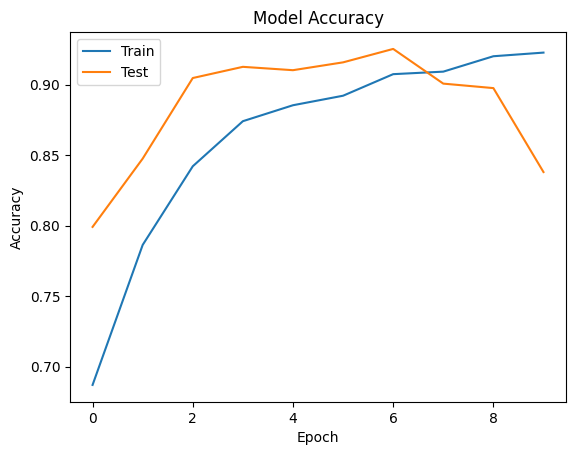

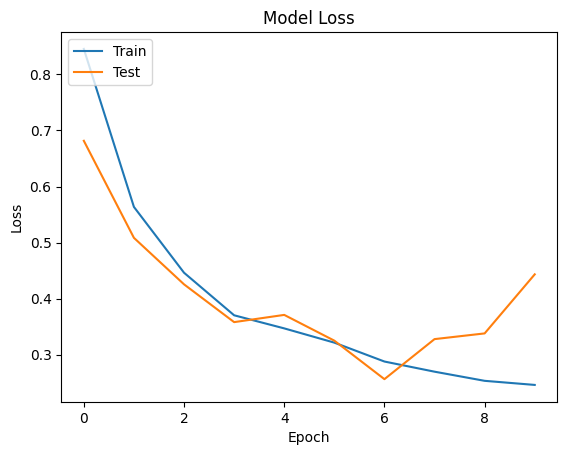

In [ ]:
history = model2.fit(
    x = train_data,
    epochs=20,
    validation_data=test_data,
    callbacks=early_stop
)

test_loss, test_accuracy = model2.evaluate(test_data)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)


# Plot training and test accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training and test loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# InceptionV3

In [ ]:
base_model3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model3.layers:
    layer.trainable = False

base_model3.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 111, 111, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 111, 111, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 109, 109, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 109, 109, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 109, 109, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 109, 109, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 109, 109, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 109, 109, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 54, 54, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 54, 54, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 54, 54, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 52, 52, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 52, 52, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
# Define the model

model3 = Sequential([
    data_augmentation,
    base_model3,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(4, activation='softmax')
])

In [ ]:
model3.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
early_stop = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)]

Epoch 1/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 332s 2s/step - accuracy: 0.9342 - loss: 0.2173 - val_accuracy: 0.9809 - val_loss: 0.0604
Epoch 2/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 370s 2s/step - accuracy: 0.9855 - loss: 0.0366 - val_accuracy: 0.9833 - val_loss: 0.0490
Epoch 3/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 339s 2s/step - accuracy: 0.9907 - loss: 0.0267 - val_accuracy: 0.9722 - val_loss: 0.0807
Epoch 4/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 367s 2s/step - accuracy: 0.9925 - loss: 0.0250 - val_accuracy: 0.9873 - val_loss: 0.0433
Epoch 5/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 386s 2s/step - accuracy: 0.9928 - loss: 0.0176 - val_accuracy: 0.9682 - val_loss: 0.0934
Epoch 6/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 326s 2s/step - accuracy: 0.9894 - loss: 0.0231 - val_accuracy: 0.9873 - val_loss: 0.0437
Epoch 7/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 341s 2s/step - accuracy: 0.9944 - loss: 0.0166 - val_accuracy: 0.9857 - val_loss: 0.0456
40/40 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.9899 - loss: 0.0311
Test Loss: 0.04559528082

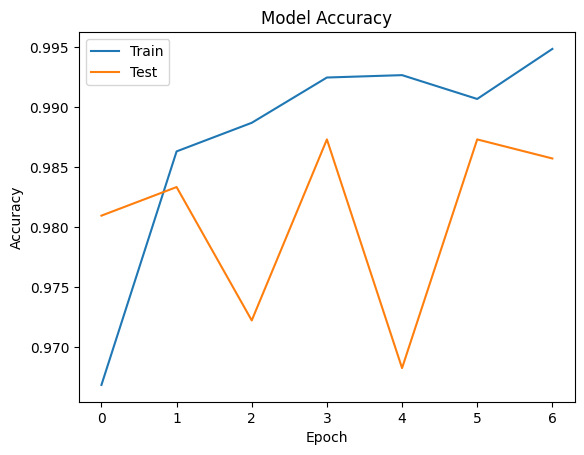

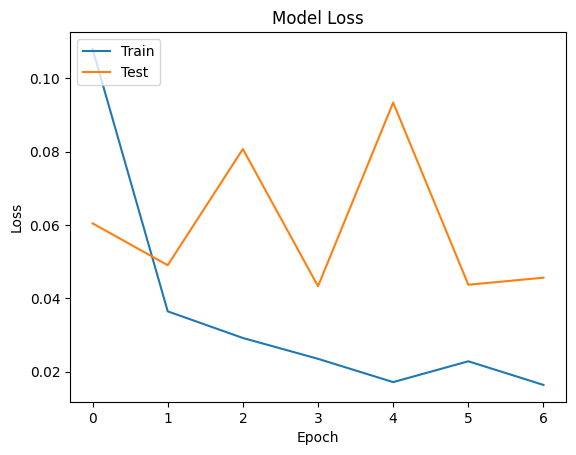

In [ ]:
history = model3.fit(
    x = train_data,
    epochs=20,
    validation_data=test_data,
    callbacks=early_stop
)

test_loss, test_accuracy = model3.evaluate(test_data)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)


# Plot training and test accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training and test loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()